### This is a fitting soft for Stark Split of H-Balmer lines in a Electric Field

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

# constants
lambda_h_alpha = 656.279
lambda_h_beta = 486.133
lambda_h_gamma = 434.0472    
lambda_h_delta = 410.1740

M = 1.008664915  # mass of hydrogen in amu

# Spectrometer 
FWHM_instrument = 0.05  # Instrumental FWHM in nm

# Gas and Plasma 
T1 = 500         # Temperature in K
T2 = 3000
weight_T2 = 0 

# Electric Field
E_input = [1, 10]   # (kV/cm). 需要计算的电场范围
E_range_rad = 0.3   # Assuming there is a E range spread. Equally weighted.

# component = 1     # π = 1, σ = 2,　π + σ = 0


###### H - split weights ######

H_alpha_pi = pd.DataFrame({
    "名称": ["H_alpha_pi"] * 6,
    "中心波长": [lambda_h_alpha] * 6,
    "k": [2, -2, 3, -3, 4, -4],
    "权重": [7.7, 7.7, 24.4, 24.4, 17.8, 17.8]
})

H_alpha_sigma = pd.DataFrame({
    "名称": ["H_alpha_sigma"] * 7,
    "中心波长": [lambda_h_alpha] * 7,
    "k": [0, 1, -1, 5, -5, 6, -6],
    "权重": [58.2, 20.5, 20.5, 0.2, 0.2, 0.2, 0.2]
})


H_beta_pi = pd.DataFrame({
    "名称": ["H_beta_pi"] * 8,
    "中心波长": [lambda_h_beta] * 8,
    "k": [2, -2, 6, -6, 8, -8, 10, -10],
    "权重": [0.5, 0.5, 4.8, 4.8, 23.0, 23.0, 21.6, 21.6]
})

H_beta_simga = pd.DataFrame({
    "名称": ["H_beta_sigma"] * 10,
    "中心波长": [lambda_h_beta] * 10,
    "k": [2, -2, 4, -4, 6, -6, 10, -10, 12, -12],
    "权重": [4.3, 4.3, 27.3, 27.3, 17.6, 17.6, 0.4, 0.4, 0.5, 0.5]
})


database ={
    "H_alpha_pi": H_alpha_pi,
    "H_alpha_sigma": H_alpha_sigma,
    "H_beta_pi": H_beta_pi,
    "H_beta_sigma": H_beta_simga
}


# Plot 
spectra_radius = 1     # (nm). Spectra radius for plotting.









In [16]:
# Lines and E-field input 

lines_to_compute = {
    #"H_alpha_sigma": [3],
    #"H_alpha_pi": [3],
    "H_beta_pi": [1],
    "H_beta_sigma": [3]
}




In [ ]:
# 底层计算函数。

def calculate_delta_lambda(data_df, E_input):
    """ 根据 E 计算 Δλ 并添加到 df """
    for index, row in data_df.iterrows():
        lmabda_cent = row["中心波长"]
        k = row["k"]

        # smallest split value, depending on lambda_cent.
        # Use the coeff. of H-beta given by Wang 2005. Other coeff. are calculated by this. 
        C = 1.517e-3 * (lmabda_cent ** 2/ lambda_h_beta**2) 

        for e in E_input:
            '''Stark Split calculation'''
            delta_lambda = C * k * e
            delta_lambda = round(delta_lambda, 5)
            col_name = f'Δλ (E={e})'
            data_df.at[index, col_name] = delta_lambda
    
    return data_df

def line_boardening_Gaussian(delta_lambda, lambda_cent, T, M, spectra_range = 0.5, FWHM_instrument = 0.02, normalize=True, sampling = 1000):
    FWHM_Dop = (7.16e-7 * (lambda_cent * np.sqrt(T/M)))
    FWHM_G = np.sqrt(FWHM_Dop**2 + FWHM_instrument**2)
    lambda_range = np.linspace(lambda_cent - spectra_range, lambda_cent + spectra_range, sampling)
    
    #      
    intensity = np.exp(-4 * np.log(2) * ((lambda_range - lambda_cent - delta_lambda) / FWHM_G)**2)
    if normalize:
        intensity = intensity / np.max(intensity)

    return pd.DataFrame({'Wavelength (nm)': lambda_range, 'Intensity': intensity})

#def find_real_peak_width()

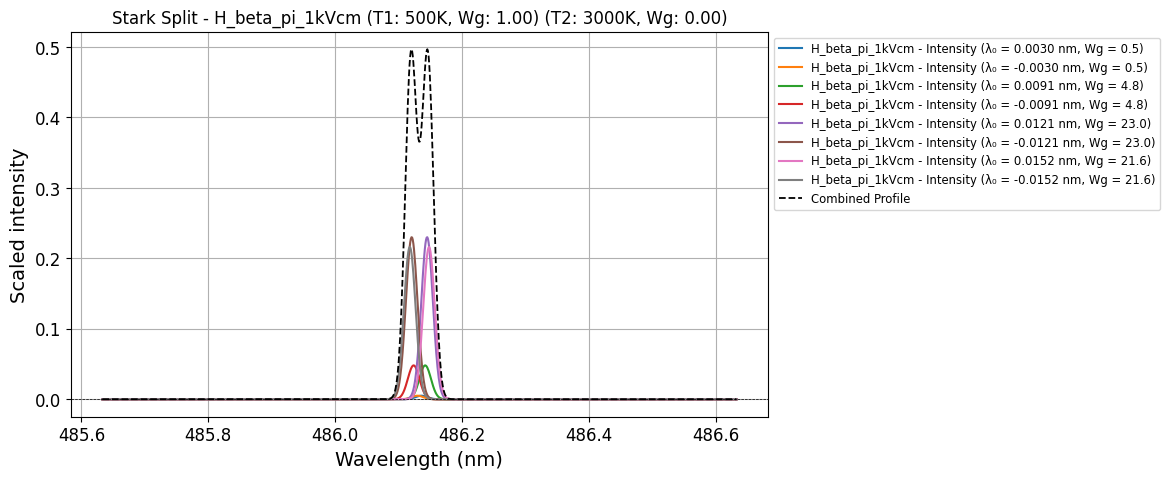

dict_keys(['H_beta_pi_1kVcm'])


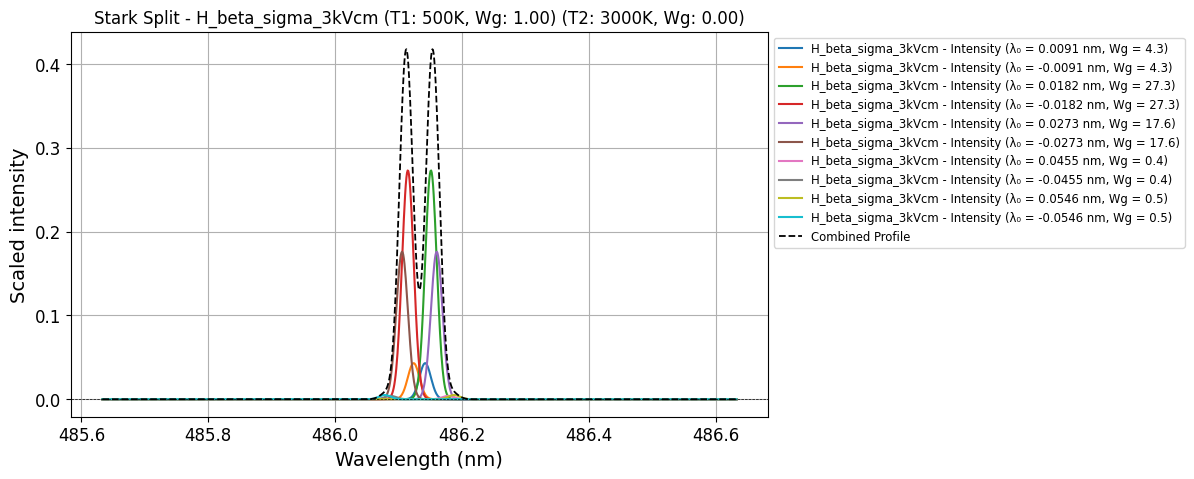

dict_keys(['H_beta_pi_1kVcm', 'H_beta_sigma_3kVcm'])


In [17]:
# Current Version 
def compute_stark_split_profile(data_df, E_input, T1, M, T2=None, weight_T2=None, mode=1, plot=True):
    """主函数。计算线宽并返回 Stark 分裂结果。
    参数：
        data_df: database 字典中的 df. 描述 Stark component 的基础信息 (k, weight)    
        E_input: 需要计算的电场强度列表。
        T2: 第二个温度 (K)。如果为None 则不计算 T2 的谱线。
        weight_T2: T2的权重。 weight_T2 + weight_T1 = 1

    返回:
        Stark_split result (dict): { key{str} = 谱线名称 + 电场强度;
                                    value(list) = 对应的[df], 
                                    [df] = [profile_1]  (T2=None)
                                    OR = [profile_1, profile_2, profil_sum]}
                    profile_1, 2, sum = 谱线形状
                    profile_df 形式 = 名称, T(K), wavelength(图的横轴范围), 各分裂谱线对 wavelength列的强度.... -1 列= Sum
    
    """
    Stark_split_result = {}     # Reset result_dict
    
    data_df = calculate_delta_lambda(data_df, E_input)

    if weight_T2 is None:
        weight_T2 = 0
    
    weight_T1 = 1 - weight_T2

    # -----------------------
    def compute_line(data_df, E, T1, M, weight_T1):
        '''计算指定 E 下的谱线剖面。
        返回 profile_df (λ): 各波长对应的强度。'''

        profile_df = pd.DataFrame()     # reset profile_df

        # 遍历 data_df 中的每一行，用于每个谱线的计算
        for index, data_row in data_df.iterrows():
            try:
                # 提取当前行的信息。
                split_lambda = float(data_row[f'Δλ (E={E})'])   # 提取 Δλ
                lambda_cent = float(data_row ['中心波长'])      # 提取中心波长
                weight = data_row["权重"]

                profile_data = line_boardening_Gaussian(split_lambda, lambda_cent, T1, M)

                # 计算加权强度， "weighted_intensity" 保存经权重调整的强度值。
                # 注意将权重从百分比转换成小数。
                weighted_intensity = profile_data['Intensity'] * (weight * weight_T1 / 100)

                # 创建列名，记录不同强度对应的波长和权重
                column_name = f'Intensity (λ₀ = {split_lambda:.4f} nm, Wg = {weight})'
                profile_df[column_name] = weighted_intensity

            except Exception as e:
                print(f"Error processing row {index}: {e}")

        # 对各列强度求和。
        sum_values = profile_df.sum(axis=1)

        # 将 sum 添加到profile_df
        profile_df['Superposition (Sum)'] = sum_values

        # 插入中心波长，T1， 谱线名称到 df 的最前几列
        profile_df.insert(0, 'Wavelength (nm)', profile_data['Wavelength (nm)'])
        profile_df.insert(0, 'T (K)', T1)                 
        profile_df.insert(0, 'Name', pd.Series([f"{data_df.iloc[0]['名称']}_{E}kVcm"] * len(profile_df)))

        # 将计算结果存储于字典中。key = 谱线名称 + 电场强度， value = profile_df 的列表
        if f"{data_df.iloc[0]['名称']}_{E}kVcm" in Stark_split_result:
            Stark_split_result[f"{data_df.iloc[0]['名称']}_{E}kVcm"].append(profile_df)
        else:
            Stark_split_result[f"{data_df.iloc[0]['名称']}_{E}kVcm"] = [profile_df]

        return profile_df

    # -----------------------

    for E in E_input:
        # 计算 T1 profile
        profile_df = compute_line(data_df, E, T1, M, weight_T1)

        # if T2 is not None, 计算 T2 profile
        if T2 is not None:
            profile_df_2 = compute_line(data_df, E, T2, M, weight_T2)

            # 求和 1 + 2 = profile_df_sum
            profile_df_sum = profile_df.copy()
            profile_df_sum['Superposition (Sum)'] += profile_df_2['Superposition (Sum)']

            # 对各 stark split 求和，得合成profile
            for col in profile_df_2.columns[3:-1]:
                profile_df_sum[col] = profile_df[col] + profile_df_2[col]

            # 更新存储结果的字典，包含 T1, T2, sum的计算结果
            Stark_split_result[f"{data_df.iloc[0]['名称']}_{E}kVcm"].append(profile_df_sum)

    # display (profile_df_2)
    
    # 可视化
    if plot is True:
        plot_stark_profiles(Stark_split_result,Stark_split_result.keys(), T1, T2, weight_T2,profile_to_plot=-1, mode = mode)
    
    
    return Stark_split_result


def plot_stark_profiles(all_profiles, keys_to_plot, T1 = None, T2 = None, weight_T2 = 0.0, profile_to_plot=-1, mode = 1): 
    """绘制指定键值对的 Stark Split Profile, 显示温度和权重。
    
    参数:
        all_profiles(dict): 存储谱线信息
            - key(str): 谱线名称 + 电场强度, like "H_alpha_sigma_1kVcm"
            - value(list): list包含profile_df. 
        
            keys_to_plot(list): 指定绘制的 key 列表.
            profile_to_plot: 指定绘制的profile (0 = profile_df (T1之谱线), 1 = profile_df_2 (T2之谱线), -1 = profile_df_sum (T1, T2合成谱线))
            mode: 1 = 绘制所有split components, 2 = 仅绘制最后一列 (所有component的sum谱线)
    
    """
    for key in keys_to_plot:        # 遍历需要绘制的profile
        if key in all_profiles:
            profiles = all_profiles[key]    # 获取键值对应的 profile_df

            plt.figure(figsize=(9, 5))

            # -----------------------------

            if mode == 1:
                
                profile_data = profiles[profile_to_plot]

                for line in profile_data.columns[3:-1]:
                    plt.plot(profile_data['Wavelength (nm)'], profile_data[line], label=f"{key} - {line}")
                
                plt.plot(profile_data['Wavelength (nm)'], profile_data['Superposition (Sum)'],'k--', label = 'Combined Profile', linewidth = 1.3) # 绘制合成线

                # 构造标题
                title = f'Stark Split - {key}'
                if T1 is not None:
                    title += f" (T1: {T1}K, Wg: {1 -weight_T2:.2f})"
                if T2 is not None:
                    title += f" (T2: {T2}K, Wg: {weight_T2:.2f})"

                plt.title(title)

            # --------------------------------
            elif mode == 2: 
                num_profiles = len(profiles) # 获取 df 的数量
                colors = plt.cm.plasma(np.linspace(0.15, 0.75, num_profiles))   # 根据 df 数量生成颜色
                
                for index, df in enumerate(profiles):
                    last_column = df.column[-1]
                    plt.plot(df['Wavelength (nm)'], df[last_column],
                            label = f"{key} - {last_column}",
                            color = colors[index])

                plt.title(f'Stark Split - {key}, T1={T1}, T2={T2}k, T1_W={1-weight_T2}')

            plt.xlabel('Wavelength (nm)', fontsize = 14)
            plt.ylabel('Scaled intensity', fontsize = 14)
            plt.grid()
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.axhline(0, color='black', linewidth = 0.5, ls = '--')
            plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1), fontsize = 'small')
            plt.show()

# 使用

result_dict = {}

for name, E_input in lines_to_compute.items():

    result_dict.update(compute_stark_split_profile(database[name], E_input, T1, M, T2, weight_T2, mode=1, plot=True))
    print(result_dict.keys())




Computing h_beta_pi for E-fields: [5] kV/cm


C:\Users\Y.M.Pan\AppData\Local\Temp\ipykernel_4396\35205262.py:134: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(intensity, wavelength)


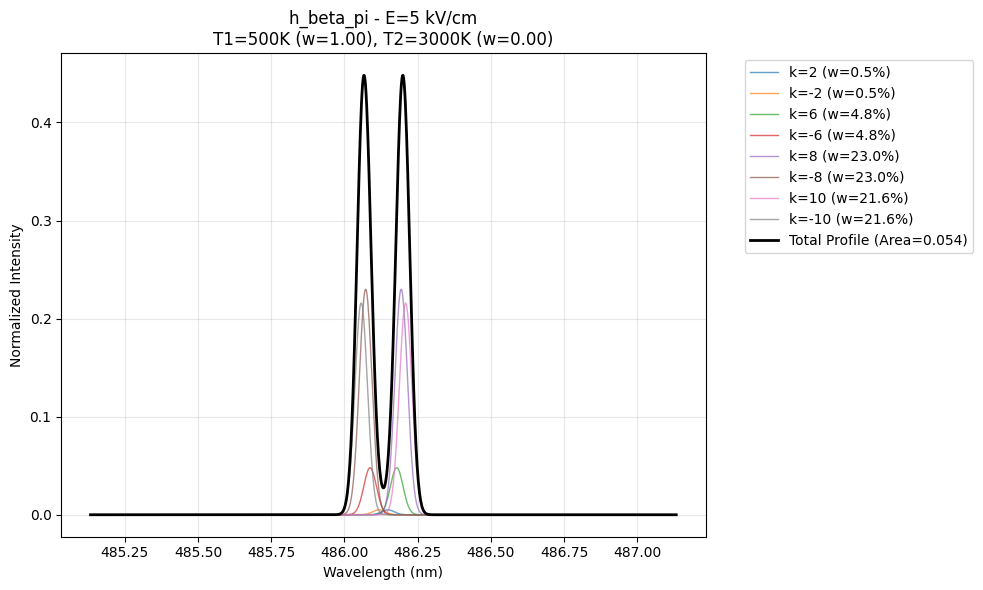

Computing h_beta_sigma for E-fields: [5] kV/cm


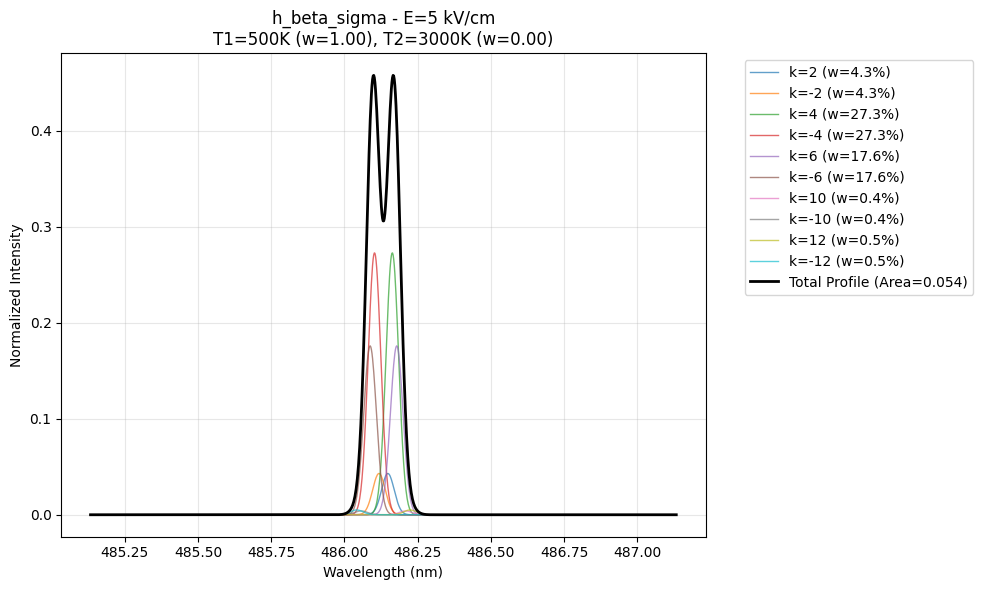

Computing h_alpha_sigma for E-fields: [5] kV/cm


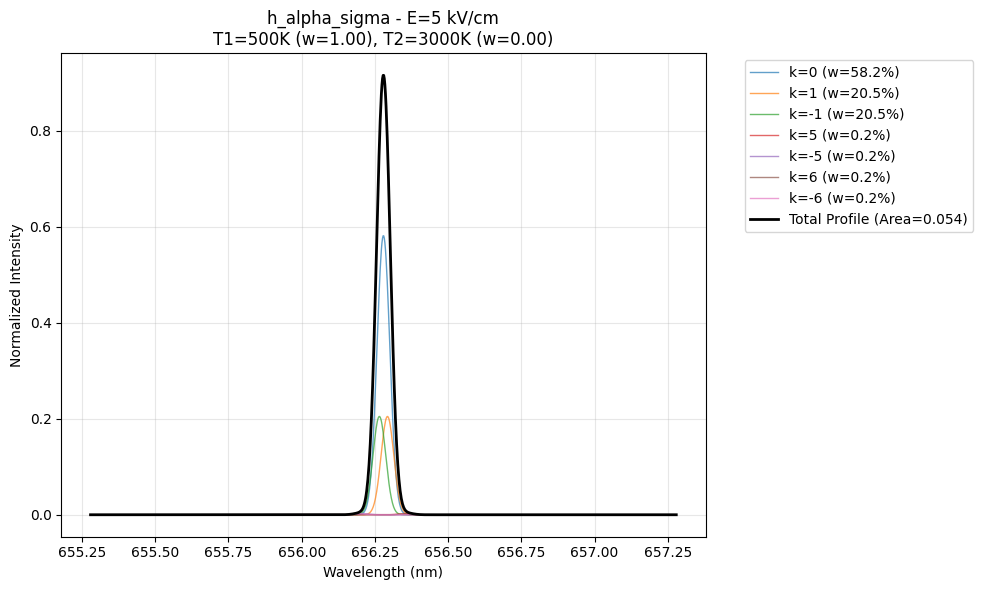


Computed profiles: ['h_beta_pi_5kV_cm', 'h_beta_sigma_5kV_cm', 'h_alpha_sigma_5kV_cm']
h_beta_pi_5kV_cm: Total area = 0.0538
h_beta_sigma_5kV_cm: Total area = 0.0540
h_alpha_sigma_5kV_cm: Total area = 0.0544


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

# Physical constants
HYDROGEN_MASS_AMU = 1.008664915
WAVELENGTHS = {
    'h_alpha': 656.279,
    'h_beta': 486.133,
    'h_gamma': 434.0472,
    'h_delta': 410.1740
}

# Stark split coefficients and weights - using DataFrame for better data manipulation
def create_stark_components():
    """Create DataFrame database for Stark components."""
    h_alpha_pi = pd.DataFrame({
        'line_name': ['h_alpha_pi'] * 6,
        'wavelength': [WAVELENGTHS['h_alpha']] * 6,
        'k': [2, -2, 3, -3, 4, -4],
        'weight': [7.7, 7.7, 24.4, 24.4, 17.8, 17.8]
    })
    
    h_alpha_sigma = pd.DataFrame({
        'line_name': ['h_alpha_sigma'] * 7,
        'wavelength': [WAVELENGTHS['h_alpha']] * 7,
        'k': [0, 1, -1, 5, -5, 6, -6],
        'weight': [58.2, 20.5, 20.5, 0.2, 0.2, 0.2, 0.2]
    })
    
    h_beta_pi = pd.DataFrame({
        'line_name': ['h_beta_pi'] * 8,
        'wavelength': [WAVELENGTHS['h_beta']] * 8,
        'k': [2, -2, 6, -6, 8, -8, 10, -10],
        'weight': [0.5, 0.5, 4.8, 4.8, 23.0, 23.0, 21.6, 21.6]
    })
    
    h_beta_sigma = pd.DataFrame({
        'line_name': ['h_beta_sigma'] * 10,
        'wavelength': [WAVELENGTHS['h_beta']] * 10,
        'k': [2, -2, 4, -4, 6, -6, 10, -10, 12, -12],
        'weight': [4.3, 4.3, 27.3, 27.3, 17.6, 17.6, 0.4, 0.4, 0.5, 0.5]
    })
    
    return {
        'h_alpha_pi': h_alpha_pi,
        'h_alpha_sigma': h_alpha_sigma,
        'h_beta_pi': h_beta_pi,
        'h_beta_sigma': h_beta_sigma
    }

# Initialize the database
STARK_COMPONENTS = create_stark_components()


def calculate_stark_shift(wavelength: float, k: int, electric_field: float) -> float:
    """Calculate Stark shift for a given component.
    
    Args:
        wavelength: Central wavelength in nm
        k: Stark component index
        electric_field: Electric field strength in kV/cm
    
    Returns:
        Wavelength shift in nm
    """
    # Coefficient based on Wang 2005, scaled by wavelength ratio
    coeff = 1.517e-3 * (wavelength**2 / WAVELENGTHS['h_beta']**2)
    return coeff * k * electric_field


def calculate_doppler_fwhm(wavelength: float, temperature: float, mass: float) -> float:
    """Calculate Doppler broadening FWHM.
    
    Args:
        wavelength: Wavelength in nm
        temperature: Temperature in K
        mass: Atomic mass in amu
    
    Returns:
        Doppler FWHM in nm
    """
    return 7.16e-7 * wavelength * np.sqrt(temperature / mass)


def generate_gaussian_profile(center_wavelength: float, shift: float, 
                            temperature: float, mass: float,
                            instrument_fwhm: float = 0.05,
                            spectral_range: float = 1.0,
                            n_points: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """Generate Gaussian line profile with Doppler and instrumental broadening.
    
    Args:
        center_wavelength: Center wavelength in nm
        shift: Wavelength shift from Stark effect in nm
        temperature: Gas temperature in K
        mass: Atomic mass in amu
        instrument_fwhm: Instrumental FWHM in nm
        spectral_range: Spectral range around center in nm
        n_points: Number of wavelength points
    
    Returns:
        Tuple of (wavelength_array, intensity_array)
    """
    doppler_fwhm = calculate_doppler_fwhm(center_wavelength, temperature, mass)
    total_fwhm = np.sqrt(doppler_fwhm**2 + instrument_fwhm**2)
    
    wavelength_array = np.linspace(
        center_wavelength - spectral_range, 
        center_wavelength + spectral_range, 
        n_points
    )
    
    # Shifted center position
    shifted_center = center_wavelength + shift
    
    # Gaussian profile
    intensity = np.exp(-4 * np.log(2) * ((wavelength_array - shifted_center) / total_fwhm)**2)
    
    return wavelength_array, intensity


def calculate_area_under_curve(wavelength: np.ndarray, intensity: np.ndarray) -> float:
    """Calculate area under the curve using trapezoidal integration.
    
    Args:
        wavelength: Wavelength array
        intensity: Intensity array
    
    Returns:
        Area under the curve
    """
    return np.trapz(intensity, wavelength)


def compute_stark_profile(line_name: str, electric_fields: List[float],
                         temperature1: float, temperature2: Optional[float] = None,
                         weight_t2: float = 0.0, instrument_fwhm: float = 0.05,
                         spectral_range: float = 1.0, n_points: int = 1000) -> Dict:
    """Compute Stark split profiles for a spectral line.
    
    Args:
        line_name: Name of the spectral line (key in STARK_COMPONENTS)
        electric_fields: List of electric field strengths in kV/cm
        temperature1: Primary temperature in K
        temperature2: Secondary temperature in K (optional)
        weight_t2: Weight of secondary temperature component [0-1]
        instrument_fwhm: Instrumental FWHM in nm
        spectral_range: Spectral range for calculation in nm
        n_points: Number of wavelength points
    
    Returns:
        Dictionary containing calculated profiles
    """
    if line_name not in STARK_COMPONENTS:
        raise ValueError(f"Unknown line: {line_name}")
    
    line_df = STARK_COMPONENTS[line_name]
    center_wavelength = line_df['wavelength'].iloc[0]
    weight_t1 = 1.0 - weight_t2
    
    results = {}
    
    for e_field in electric_fields:
        profile_key = f"{line_name}_{e_field}kV_cm"
        
        # Initialize wavelength array (same for all components)
        wavelength_array = np.linspace(
            center_wavelength - spectral_range,
            center_wavelength + spectral_range,
            n_points
        )
        
        # Calculate profiles for each temperature
        profiles_t1 = []
        profiles_t2 = []
        
        component_data = []
        
        # Iterate through DataFrame rows
        for _, row in line_df.iterrows():
            k = row['k']
            weight = row['weight'] / 100.0  # Convert percentage to fraction
            
            # Calculate Stark shift
            shift = calculate_stark_shift(center_wavelength, k, e_field)
            
            # Generate profiles for each temperature
            _, intensity_t1 = generate_gaussian_profile(
                center_wavelength, shift, temperature1, HYDROGEN_MASS_AMU,
                instrument_fwhm, spectral_range, n_points
            )
            
            # Apply weight and temperature weight
            weighted_intensity_t1 = intensity_t1 * weight * weight_t1
            profiles_t1.append(weighted_intensity_t1)
            
            # Store component information
            component_info = {
                'k': k,
                'weight': row['weight'],
                'shift': shift,
                'intensity_t1': weighted_intensity_t1,
                'area_t1': calculate_area_under_curve(wavelength_array, weighted_intensity_t1)
            }
            
            if temperature2 is not None:
                _, intensity_t2 = generate_gaussian_profile(
                    center_wavelength, shift, temperature2, HYDROGEN_MASS_AMU,
                    instrument_fwhm, spectral_range, n_points
                )
                weighted_intensity_t2 = intensity_t2 * weight * weight_t2
                profiles_t2.append(weighted_intensity_t2)
                
                component_info['intensity_t2'] = weighted_intensity_t2
                component_info['area_t2'] = calculate_area_under_curve(wavelength_array, weighted_intensity_t2)
                component_info['total_intensity'] = weighted_intensity_t1 + weighted_intensity_t2
                component_info['total_area'] = component_info['area_t1'] + component_info['area_t2']
            else:
                component_info['total_intensity'] = weighted_intensity_t1
                component_info['total_area'] = component_info['area_t1']
            
            component_data.append(component_info)
        
        # Sum all components
        total_profile = np.sum(profiles_t1, axis=0)
        if temperature2 is not None:
            total_profile += np.sum(profiles_t2, axis=0)
        
        # Store results
        results[profile_key] = {
            'wavelength': wavelength_array,
            'total_profile': total_profile,
            'total_area': calculate_area_under_curve(wavelength_array, total_profile),
            'components': component_data,
            'parameters': {
                'line_name': line_name,
                'electric_field': e_field,
                'temperature1': temperature1,
                'temperature2': temperature2,
                'weight_t2': weight_t2,
                'instrument_fwhm': instrument_fwhm,
                'spectral_range': spectral_range
            }
        }
    
    return results


def plot_stark_profiles(results: Dict, show_components: bool = True,
                       show_individual_temps: bool = False) -> None:
    """Plot Stark split profiles.
    
    Args:
        results: Results dictionary from compute_stark_profile
        show_components: Whether to show individual Stark components
        show_individual_temps: Whether to show individual temperature components
    """
    for profile_key, data in results.items():
        plt.figure(figsize=(10, 6))
        
        wavelength = data['wavelength']
        total_profile = data['total_profile']
        components = data['components']
        params = data['parameters']
        
        # Plot individual components if requested
        if show_components:
            for i, comp in enumerate(components):
                if show_individual_temps and 'intensity_t2' in comp:
                    plt.plot(wavelength, comp['intensity_t1'], 
                           alpha=0.6, linestyle='--',
                           label=f"k={comp['k']}, T1={params['temperature1']}K")
                    plt.plot(wavelength, comp['intensity_t2'], 
                           alpha=0.6, linestyle=':',
                           label=f"k={comp['k']}, T2={params['temperature2']}K")
                else:
                    plt.plot(wavelength, comp['total_intensity'], 
                           alpha=0.7, linewidth=1,
                           label=f"k={comp['k']} (w={comp['weight']}%)")
        
        # Plot total profile
        plt.plot(wavelength, total_profile, 'k-', linewidth=2, 
                label=f'Total Profile (Area={data["total_area"]:.3f})')
        
        # Formatting
        title = f'{params["line_name"]} - E={params["electric_field"]} kV/cm'
        if params['temperature2'] is not None:
            title += f'\nT1={params["temperature1"]}K (w={1-params["weight_t2"]:.2f}), '
            title += f'T2={params["temperature2"]}K (w={params["weight_t2"]:.2f})'
        else:
            title += f'\nT={params["temperature1"]}K'
        
        plt.title(title)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Normalized Intensity')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


def analyze_stark_lines(lines_config: Dict[str, List[float]], 
                       temperature1: float = 500,
                       temperature2: Optional[float] = None,
                       weight_t2: float = 0.0,
                       instrument_fwhm: float = 0.05,
                       spectral_range: float = 1.0,
                       plot_results: bool = True) -> Dict:
    """Analyze multiple Stark lines with given configuration.
    
    Args:
        lines_config: Dictionary mapping line names to electric field lists
        temperature1: Primary temperature in K
        temperature2: Secondary temperature in K (optional)
        weight_t2: Weight of secondary temperature component
        instrument_fwhm: Instrumental FWHM in nm
        spectral_range: Spectral range for calculation in nm
        plot_results: Whether to plot the results
    
    Returns:
        Dictionary containing all computed profiles
    """
    all_results = {}
    
    for line_name, electric_fields in lines_config.items():
        print(f"Computing {line_name} for E-fields: {electric_fields} kV/cm")
        
        line_results = compute_stark_profile(
            line_name=line_name,
            electric_fields=electric_fields,
            temperature1=temperature1,
            temperature2=temperature2,
            weight_t2=weight_t2,
            instrument_fwhm=instrument_fwhm,
            spectral_range=spectral_range
        )
        
        all_results.update(line_results)
        
        if plot_results:
            plot_stark_profiles(line_results, show_components=True)
    
    return all_results


# Example usage
if __name__ == "__main__":
    # Configuration
    lines_to_analyze = {
        "h_beta_pi": [5],
        "h_beta_sigma": [5],
        "h_alpha_sigma": [5]
    }
    
    # Run analysis
    results = analyze_stark_lines(
        lines_config=lines_to_analyze,
        temperature1=500,
        temperature2=3000,
        weight_t2=0.0,
        instrument_fwhm=0.05,
        spectral_range=1.0,
        plot_results=True
    )
    
    # Print summary
    print(f"\nComputed profiles: {list(results.keys())}")
    for key, data in results.items():
        print(f"{key}: Total area = {data['total_area']:.4f}")